# Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn

import os


# Load Dataset :    CIFAR-10, noisy_image

#### - Load dataset

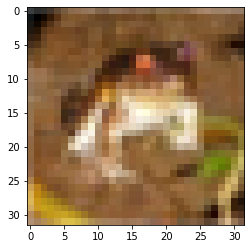

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train/255.0, x_test/255.0       # pre-processing: scaling
y_train, y_test = x_train, x_test

plt.imshow(x_train[0])

#### - Load Noisy image ( targe image )

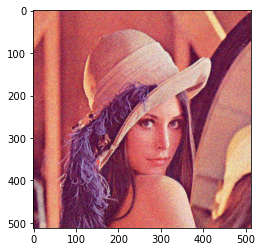

(<matplotlib.image.AxesImage at 0x203df7a4da0>, None)

In [4]:
noisy_image_im = Image.open('../data/noisy.png')
noisy_image = np.array(noisy_image_im)/255.0

plt.imshow(noisy_image_im), plt.show()

# Training NN models

#### - Noisy neural network

In [5]:
noiseNN = tf.keras.models.Sequential([
    tf.keras.layers.GaussianNoise(0.1, input_shape=(32,32,3)),
])

tensor_input = tf.keras.layers.Input((32,32,3, ), name='anchor_input')
noisy_input = noiseNN(tensor_input)

#### - Setting learning rate...

In [6]:
learning_rate = 1e-4

if not os.path.isdir(str(learning_rate)):
       os.makedirs(os.path.join(str(learning_rate)))

#### - Check performance of prediction from trained model

In [7]:
def restore_image(trained_model, image):
    input_shape = (32,32,3)
    for row_idx in range(int(image.shape[0]/input_shape[0])):
        for col_idx in range(int(image.shape[1]/input_shape[1])):
            row_s = input_shape[0] * row_idx
            col_s = input_shape[1] * col_idx
            row_e = row_s + input_shape[0]
            col_e = col_s + input_shape[1]
            image_slice = image[row_s:row_e, col_s:col_e,:]
            
            
            restored_slice = trained_model.predict(np.array([image_slice]))[0]
            if col_idx == 0:
                restored_partition = restored_slice
            else:
                restored_partition = np.concatenate((restored_partition, restored_slice), axis=1)

        if row_idx == 0:
            restored_image = restored_partition
        else:
            restored_image = np.concatenate((restored_image, restored_partition), axis=0)
                
    return restored_image
        

## a) Model #1

#### - Build model

In [8]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input)
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
anchor_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         114307    
Total params: 114,307
Trainable params: 114,307
Non-trainable params: 0
_________________________________________________________________


#### - Train model and save it

In [9]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # train model
# result = model.fit(
#     x_train, y_train, 
#     batch_size = 32, 
#     epochs = 100,
#     shuffle = True,
#     verbose = True,
#     validation_data = (x_test, y_test),
#     callbacks=[callback]
# )

# # save model
# model_core.save_weights(str(learning_rate)+'/model1.hdf5')

#### - show results

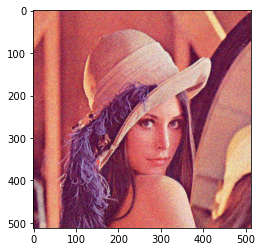

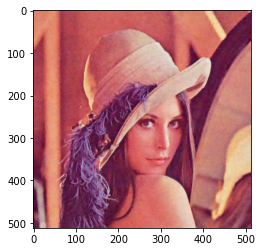

(<matplotlib.image.AxesImage at 0x203e2aa27b8>, None)

In [10]:
# load model
#model_core.load_weights('trained_models/epoch_100/'+str(learning_rate)+'/model1.hdf5')
model_core.load_weights(str(learning_rate)+'/model1.hdf5')

# predict
restored_image = restore_image(model_core, noisy_image)

# convert to uint8 format
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)

# save it
image_name = str(learning_rate)+'/Model1.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

# show results
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()

### Model #2

In [11]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input) + noisy_input
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 3)    0           anchor_input[0][0]               
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 3)    114307      sequential[1][0]                 
__________________________________________________________________________________________________
tf_op_layer_add (TensorFlowOpLa [(None, 32, 32, 3)]  0           sequential_2[1][0]               
                                                                 sequential[1][0]           

In [12]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # train model
# result = model.fit(
#     x_train, y_train, 
#     batch_size = 32, 
#     epochs = 100,
#     shuffle = True,
#     verbose = True,
#     validation_data = (x_test, y_test),
#     callbacks=[callback]
# )

# # save model
# model_core.save_weights(str(learning_rate)+'/model2.hdf5')

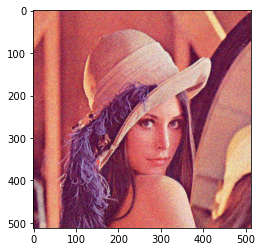

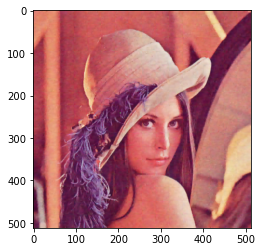

(<matplotlib.image.AxesImage at 0x203e2abe748>, None)

In [13]:
# load model
#model_core.load_weights('trained_models/epoch_100/'+str(learning_rate)+'/model2.hdf5')
model_core.load_weights(str(learning_rate)+'/model1.hdf5')

# predict
restored_image = noisy_image + restore_image(model_core, noisy_image)

# convert to uint8 format
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)

# save it
image_name = str(learning_rate)+'/Model2.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

# show results
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()

### Model #3

In [14]:
model_core = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(32,32,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.Conv2D(3, (3,3), padding='same')
])

restored_output = model_core(noisy_input) + noisy_input
model = tf.keras.models.Model(inputs=tensor_input, outputs=restored_output)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.Accuracy()]
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 3)    0           anchor_input[0][0]               
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 32, 32, 3)    115331      sequential[1][0]                 
__________________________________________________________________________________________________
tf_op_layer_add_1 (TensorFlowOp [(None, 32, 32, 3)]  0           sequential_3[1][0]               
                                                                 sequential[1][0]           

In [15]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# # train model
# result = model.fit(
#     x_train, y_train, 
#     batch_size = 32, 
#     epochs = 100,
#     shuffle = True,
#     verbose = True,
#     validation_data = (x_test, y_test),
#     callbacks=[callback]
# )

# # save model
# model_core.save_weights(str(learning_rate)+'/model3.hdf5')

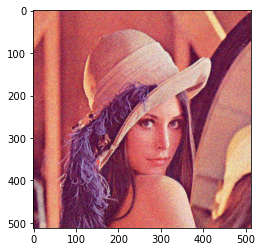

(<matplotlib.image.AxesImage at 0x203e19decf8>, None)

In [16]:
# load model
#model_core.load_weights('trained_models/epoch_100/'+str(learning_rate)+'/model3.hdf5')
model_core.load_weights(str(learning_rate)+'/model1.hdf5')

# predict
restored_image = noisy_image + restore_image(model_core, noisy_image)

# convert to uint8 format
restored_image *= 255.0
restored_image = restored_image.astype(np.uint8)

# save it
image_name = str(learning_rate)+'/Model3.png'
restored_image_im = Image.fromarray(restored_image)
restored_image_im.save(image_name)

# show results
plt.imshow(noisy_image_im), plt.show()
plt.imshow(restored_image_im), plt.show()

# Compare Results

In [17]:
restored_image_1 = Image.open(str(learning_rate)+'/Model1.png')
restored_image_2 = Image.open(str(learning_rate)+'/Model2.png')
restored_image_3 = Image.open(str(learning_rate)+'/Model3.png')

fig = plt.figure(figsize=(40,40))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(noisy_image), ax1.set_title('noisy_image', fontsize=40)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(restored_image_1), ax2.set_title('model1', fontsize=40)
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(restored_image_2), ax3.set_title('model2', fontsize=40)
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(restored_image_3), ax4.set_title('model3', fontsize=40)

fig.show()

C:\Users\dajin\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
